In [ ]:
# 1. 导入包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans



sns.set(style="whitegrid")
np.random.seed(42)


In [2]:
# 2. 读取老师生成的 CSV
train_beats = np.genfromtxt('./train_beats.csv', delimiter=',')
test_beats = np.genfromtxt('./test_beats.csv', delimiter=',')

train_patients = np.genfromtxt('./train_patients.csv', delimiter=',')
test_patients = np.genfromtxt('./test_patients.csv', delimiter=',')

all_data = np.genfromtxt('./all_data.csv', delimiter=',')

print("train_beats:", train_beats.shape)
print("test_beats:", test_beats.shape)
print("train_patients:", train_patients.shape)
print("test_patients:", test_patients.shape)
print("all_data:", all_data.shape)


train_beats: (30952, 277)
test_beats: (37442, 277)
train_patients: (200352, 277)
test_patients: (14482, 277)
all_data: (149768, 277)


In [3]:
# 公共映射
label_to_name = {
    1: 'N',  # Normal
    2: 'L',  # LBBB
    3: 'R',  # RBBB
    4: 'V',  # PVC
    5: 'A',  # APB
    6: 'F',  # Fusion
    7: 'f',  # Fusion paced+normal
    8: '/',  # Paced
}

def split_X_y_pid(data):
    X = data[:, :275]
    y = data[:, 275].astype(int)
    pid = data[:, 276].astype(int)
    return X, y, pid

X_all, y_all, pid_all = split_X_y_pid(all_data)


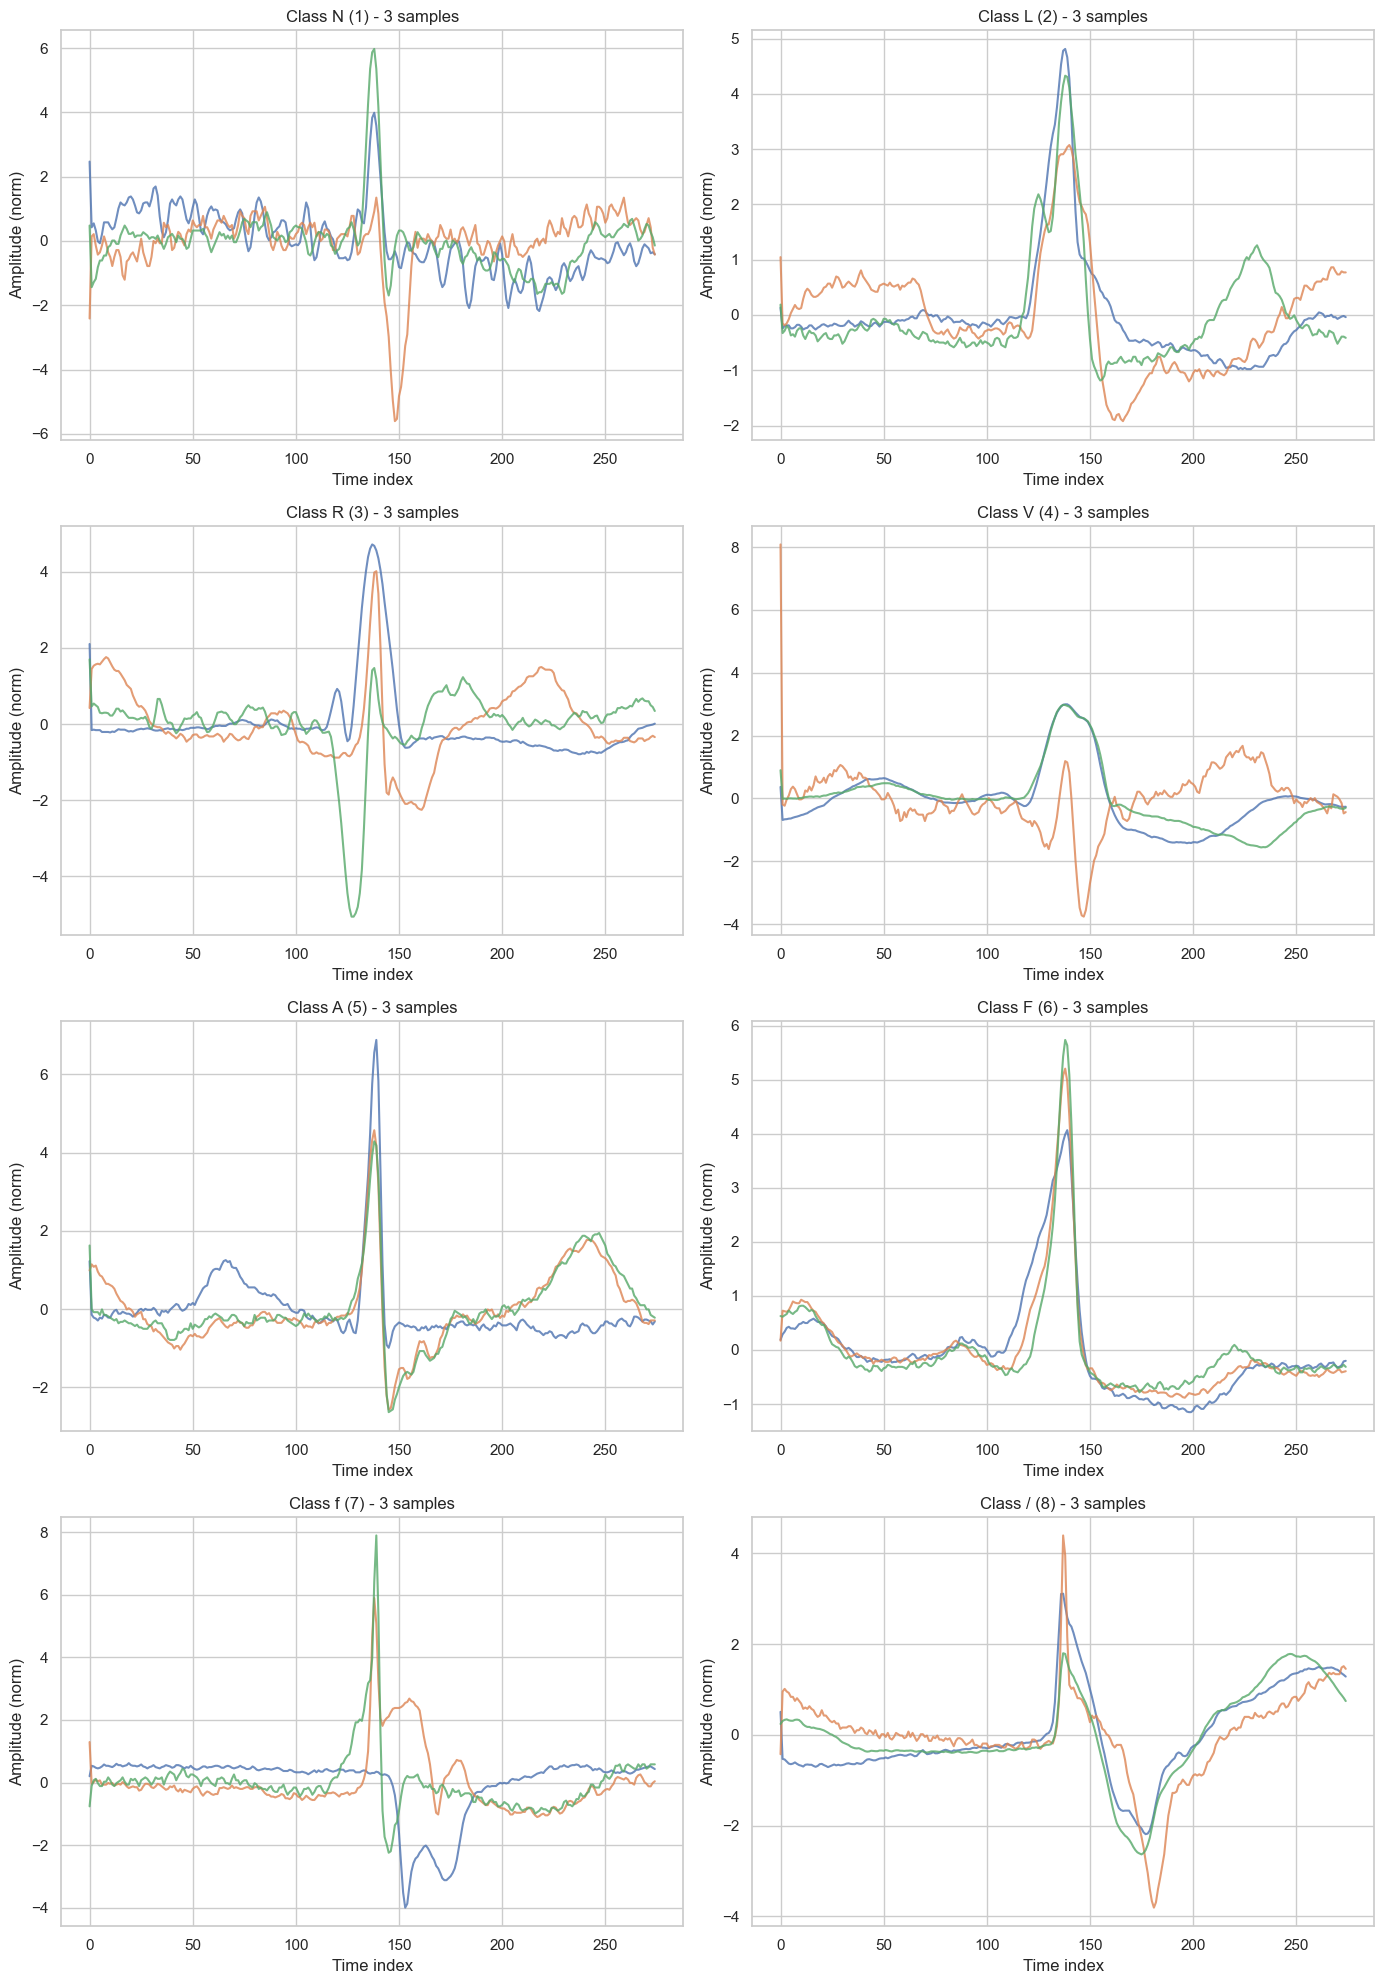

In [4]:
# def plot_example_beats(X, y, n_per_class=3, title_prefix="Examples of 8 arrhythmia classes"):
#     target_labels = [1,2,3,4,5,6,7,8]  # 只画这 8 类
#     n_classes = len(target_labels)

#     rows = n_classes
#     cols = n_per_class
    
#     plt.figure(figsize=(4*cols, 2.2*rows))

#     for r, label in enumerate(target_labels):
#         indices = np.where(y == label)[0]
        
#         if len(indices) == 0:
#             print(f"⚠️ 类别 {label} 在数据中没有样本，跳过")
#             continue
        
#         # 选择 sample
#         n_show = min(n_per_class, len(indices))
#         chosen = np.random.choice(indices, size=n_show, replace=False)

#         for c, idx in enumerate(chosen):
#             plt.subplot(rows, cols, r * cols + c + 1)
#             plt.plot(X[idx])
#             plt.title(f"Class {label_to_name[label]} ({label})")
#             if r == rows - 1:
#                 plt.xlabel("Time index")
#             if c == 0:
#                 plt.ylabel("Amplitude (norm)")

#     plt.suptitle(title_prefix)
#     plt.tight_layout(rect=[0, 0, 1, 0.98])
#     plt.show()


# # 调用：
# plot_example_beats(X_all, y_all, n_per_class=3)


def plot_each_class_combined(X, y, n_per_class=3):
    target_labels = [1,2,3,4,5,6,7,8]  # eight classes
    
    plt.figure(figsize=(14, 20))
    
    for i, label in enumerate(target_labels, 1):
        plt.subplot(4, 2, i)  # 八个子图，4 行 2 列
        
        indices = np.where(y == label)[0]
        if len(indices) == 0:
            plt.title(f"Class {label_to_name[label]} ({label}) - No samples")
            continue
        
        # 随机选 3 条心拍曲线
        n_show = min(n_per_class, len(indices))
        chosen = np.random.choice(indices, size=n_show, replace=False)
        
        for idx in chosen:
            plt.plot(X[idx], alpha=0.8)
        
        plt.title(f"Class {label_to_name[label]} ({label}) - {n_show} samples")
        plt.xlabel("Time index")
        plt.ylabel("Amplitude (norm)")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


# 调用
plot_each_class_combined(X_all, y_all, n_per_class=3)


In [5]:
def evaluate_and_report(model, X_train, y_train, X_test, y_test, description=""):
    print("="*60)
    print(f"Model: {description}")
    print("="*60)

    # 拟合
    model.fit(X_train, y_train)

    # 预测
    y_pred = model.predict(X_test)

    # 基础指标
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred, labels=sorted(np.unique(y_test)))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=[label_to_name.get(l, str(l)) for l in sorted(np.unique(y_test))],
                yticklabels=[label_to_name.get(l, str(l)) for l in sorted(np.unique(y_test))],
                cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {description}")
    plt.tight_layout()
    plt.show()

    return acc, prec, rec, f1, cm


In [6]:
#避免抽样不平衡
def reduce_by_class(X, y, pid, max_per_class=1000):
    X_new, y_new, pid_new = [], [], []
    labels = np.unique(y)
    for label in labels:
        idx = np.where(y == label)[0]
        take = min(max_per_class, len(idx))
        chosen = np.random.choice(idx, take, replace=False)
        X_new.append(X[chosen])
        y_new.append(y[chosen])
        pid_new.append(pid[chosen])
    return (
        np.vstack(X_new),
        np.concatenate(y_new),
        np.concatenate(pid_new)
    )


In [7]:
# 准备 beat holdout 的训练测试集
X_train_beats, y_train_beats, pid_train_beats = split_X_y_pid(train_beats)
X_test_beats, y_test_beats, pid_test_beats = split_X_y_pid(test_beats)

print("Beat holdout - train:", X_train_beats.shape, y_train_beats.shape)
print("Beat holdout - test :", X_test_beats.shape, y_test_beats.shape)


Beat holdout - train: (30952, 275) (30952,)
Beat holdout - test : (37442, 275) (37442,)


In [8]:
# ⭐ 在这里缩小数据 ⭐
X_train_beats, y_train_beats, pid_train_beats = reduce_by_class(
    X_train_beats, y_train_beats, pid_train_beats, max_per_class=800
)

X_test_beats, y_test_beats, pid_test_beats = reduce_by_class(
    X_test_beats, y_test_beats, pid_test_beats, max_per_class=800
)


Model: SVM (RBF) - Beat holdout
Accuracy : 0.9574
Precision: 0.9578
Recall   : 0.9574
F1-score : 0.9574

Classification report:

              precision    recall  f1-score   support

           1       0.90      0.94      0.92       800
           2       0.99      0.99      0.99       800
           3       0.99      0.99      0.99       800
           4       0.95      0.93      0.94       800
           5       0.95      0.92      0.93       750
           6       0.87      0.89      0.88       226
           7       0.96      0.97      0.96       395
           8       0.99      0.99      0.99       800

    accuracy                           0.96      5371
   macro avg       0.95      0.95      0.95      5371
weighted avg       0.96      0.96      0.96      5371



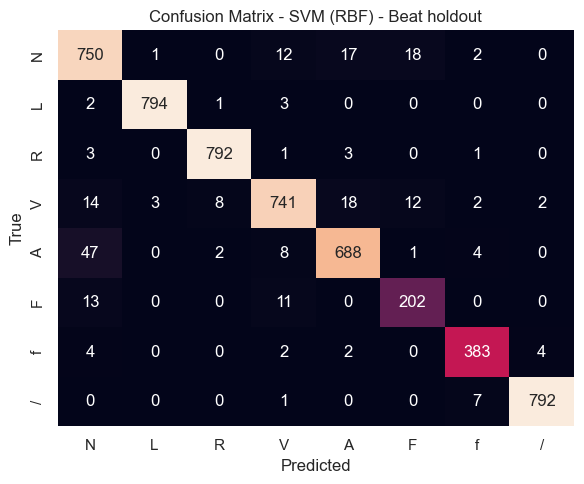

In [9]:
svm_beat = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=5.0, gamma='scale', class_weight=None, random_state=42)
)

acc_b, prec_b, rec_b, f1_b, cm_b = evaluate_and_report(
    svm_beat,
    X_train_beats, y_train_beats,
    X_test_beats,  y_test_beats,
    description="SVM (RBF) - Beat holdout"
)


In [10]:
# 准备 patient holdout 的训练测试集
X_train_pat, y_train_pat, pid_train_pat = split_X_y_pid(train_patients)
X_test_pat, y_test_pat, pid_test_pat = split_X_y_pid(test_patients)

print("Patient holdout - train:", X_train_pat.shape, y_train_pat.shape)
print("Patient holdout - test :", X_test_pat.shape, y_test_pat.shape)


Patient holdout - train: (200352, 275) (200352,)
Patient holdout - test : (14482, 275) (14482,)


In [11]:
# ⭐ 在这里缩小数据 ⭐
X_train_pat, y_train_pat, pid_train_pat = reduce_by_class(
    X_train_pat, y_train_pat, pid_train_pat, max_per_class=800
)

X_test_pat, y_test_pat, pid_test_pat = reduce_by_class(
    X_test_pat, y_test_pat, pid_test_pat, max_per_class=800
)


Model: SVM (RBF) - Patient holdout
Accuracy : 0.9638
Precision: 0.9701
Recall   : 0.9638
F1-score : 0.9667

Classification report:

              precision    recall  f1-score   support

           1       0.97      0.94      0.95       800
           4       0.98      0.97      0.98       800
           5       0.00      0.00      0.00         0
           6       0.92      0.97      0.94       387
           7       0.98      0.96      0.97       800
           8       0.98      0.98      0.98       800

    accuracy                           0.96      3587
   macro avg       0.80      0.80      0.80      3587
weighted avg       0.97      0.96      0.97      3587



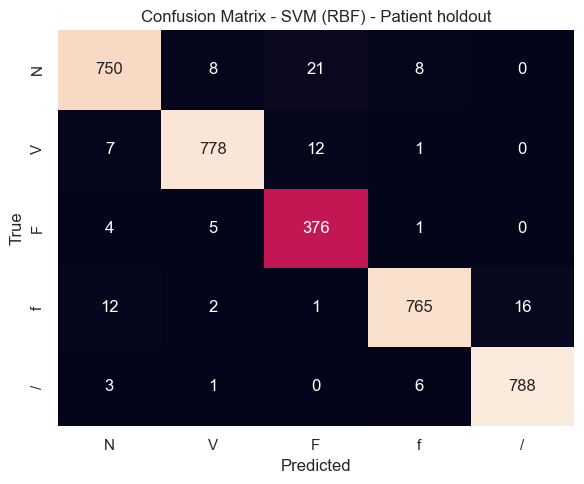

In [12]:
svm_patient = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=5.0, gamma='scale', class_weight=None, random_state=42)
)

acc_p, prec_p, rec_p, f1_p, cm_p = evaluate_and_report(
    svm_patient,
    X_train_pat, y_train_pat,
    X_test_pat,  y_test_pat,
    description="SVM (RBF) - Patient holdout"
)


In [13]:
def permutation_feature_importance_slices_verbose(
    base_model,
    X, y,
    n_slices=5,
    n_splits=5,
    metric="accuracy"
):

    n_samples, n_features = X.shape
    assert n_features == 275, "期望每个 ECG 样本 275 个时间点"

    slice_len = n_features // n_slices  # 每个 slice 的长度
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    all_importances = np.zeros((n_splits, n_slices))

    print(f"✨ 开始计算 Permutation Feature Importance")
    print(f"  → 使用 {n_splits}-fold CV")
    print(f"  → 使用 {n_slices} 个 slices，每 slice ≈ {slice_len} 点")
    print("="*60)

    fold_idx = 0
    for train_idx, test_idx in skf.split(X, y):

        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        print(f"\n📌 Fold {fold_idx+1}/{n_splits} 开始训练模型...")
        start_time = time.time()

        model = copy.deepcopy(base_model)
        model.fit(X_tr, y_tr)

        # baseline score
        y_pred = model.predict(X_te)
        base_score = accuracy_score(y_te, y_pred)

        print(f"   ✓ baseline accuracy = {base_score:.4f}")
        print(f"   ✓ 开始对 slices 做 permutation...")

        # 对每个 slice 做 permutation
        for s in range(n_slices):
            slice_start = s * slice_len
            slice_end = n_features if s == n_slices - 1 else (s + 1) * slice_len

            # 输出 slice 进度
            print(f"     → slice {s+1}/{n_slices}  (范围 {slice_start}:{slice_end})", end='')
            
            X_te_perm = X_te.copy()
            # 随机打乱每个样本的 slice
            for i in range(X_te_perm.shape[0]):
                seg = X_te_perm[i, slice_start:slice_end].copy()
                np.random.shuffle(seg)
                X_te_perm[i, slice_start:slice_end] = seg

            y_perm_pred = model.predict(X_te_perm)
            perm_score = accuracy_score(y_te, y_perm_pred)

            importance = base_score - perm_score
            all_importances[fold_idx, s] = importance

            print(f"  完成，importance Δ={importance:.4f}")

        elapsed = time.time() - start_time
        print(f"📎 Fold {fold_idx+1} 完成，用时 {elapsed:.2f} 秒")

        fold_idx += 1

    print("\n✨ 所有 folds 完成！计算平均 importance 中...")
    mean_importances = all_importances.mean(axis=0)
    print("🎉 完成！每个 slice 的 importance 如下：")
    print(mean_importances)

    return mean_importances


In [14]:
X_all, y_all, pid_all = split_X_y_pid(all_data)

svm_for_pfi = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=5.0, gamma='scale', random_state=42)
)

svm_importances = permutation_feature_importance_slices_verbose(
    svm_for_pfi,
    X_all, y_all,
    n_slices=5,
    n_splits=5
)

print("SVM slice importances:", svm_importances)


✨ 开始计算 Permutation Feature Importance
  → 使用 5-fold CV
  → 使用 5 个 slices，每 slice ≈ 55 点

📌 Fold 1/5 开始训练模型...
   ✓ baseline accuracy = 0.9899
   ✓ 开始对 slices 做 permutation...
     → slice 1/5  (范围 0:55)  完成，importance Δ=0.0112
     → slice 2/5  (范围 55:110)  完成，importance Δ=0.0133
     → slice 3/5  (范围 110:165)  完成，importance Δ=0.2264
     → slice 4/5  (范围 165:220)  完成，importance Δ=0.0549
     → slice 5/5  (范围 220:275)  完成，importance Δ=0.0177
📎 Fold 1 完成，用时 352.99 秒

📌 Fold 2/5 开始训练模型...
   ✓ baseline accuracy = 0.9906
   ✓ 开始对 slices 做 permutation...
     → slice 1/5  (范围 0:55)  完成，importance Δ=0.0127
     → slice 2/5  (范围 55:110)  完成，importance Δ=0.0160
     → slice 3/5  (范围 110:165)  完成，importance Δ=0.2324
     → slice 4/5  (范围 165:220)  完成，importance Δ=0.0559
     → slice 5/5  (范围 220:275)  完成，importance Δ=0.0166
📎 Fold 2 完成，用时 340.38 秒

📌 Fold 3/5 开始训练模型...
   ✓ baseline accuracy = 0.9896
   ✓ 开始对 slices 做 permutation...
     → slice 1/5  (范围 0:55)  完成，importance Δ=0.0114
     → sl

In [15]:
# X_all, y_all, pid_all = split_X_y_pid(all_data)

# rf_for_pfi = make_pipeline(
#     StandardScaler(),
#     RandomForestClassifier(
#         n_estimators=200,
#         max_depth=None,
#         random_state=42,
#         n_jobs=-1   # 多核加速
#     )
# )

# rf_importances = permutation_feature_importance_slices_verbose(
#     rf_for_pfi,
#     X_all, y_all,
#     n_slices=11,
#     n_splits=5
# )

# print("RF slice importances:", rf_importances)


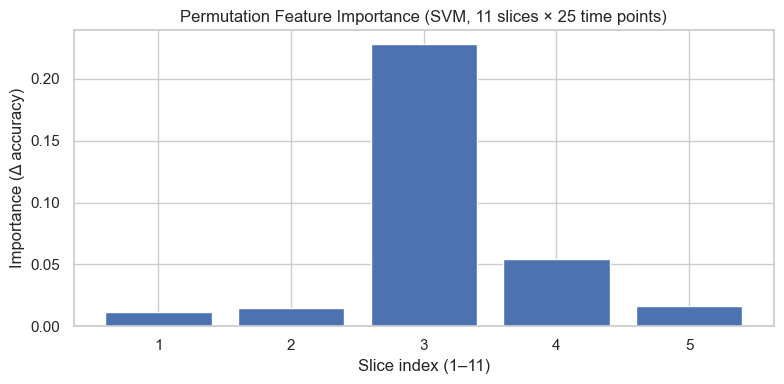

In [17]:
plt.figure(figsize=(8,4))
slice_indices = np.arange(1, 6)
plt.bar(slice_indices, svm_importances)
plt.xlabel("Slice index (1–11)")
plt.ylabel("Importance (Δ accuracy)")
plt.title("Permutation Feature Importance (SVM, 11 slices × 25 time points)")
plt.xticks(slice_indices)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(8,4))
# slice_indices = np.arange(1, 12)
# plt.bar(slice_indices, rf_importances)
# plt.xlabel("Slice index (1–11)")
# plt.ylabel("Importance (Δ accuracy)")
# plt.title("Permutation Feature Importance (Random Forest, 11 slices × 25 time points)")
# plt.xticks(slice_indices)
# plt.tight_layout()
# plt.show()

Model: Random Forest - Beat holdout
Accuracy : 0.9454
Precision: 0.9455
Recall   : 0.9454
F1-score : 0.9453

Classification report:

              precision    recall  f1-score   support

           1       0.88      0.92      0.90       800
           2       0.99      0.99      0.99       800
           3       0.96      0.97      0.96       800
           4       0.94      0.93      0.94       800
           5       0.92      0.87      0.89       750
           6       0.93      0.88      0.90       226
           7       0.94      0.96      0.95       395
           8       0.99      0.99      0.99       800

    accuracy                           0.95      5371
   macro avg       0.94      0.94      0.94      5371
weighted avg       0.95      0.95      0.95      5371



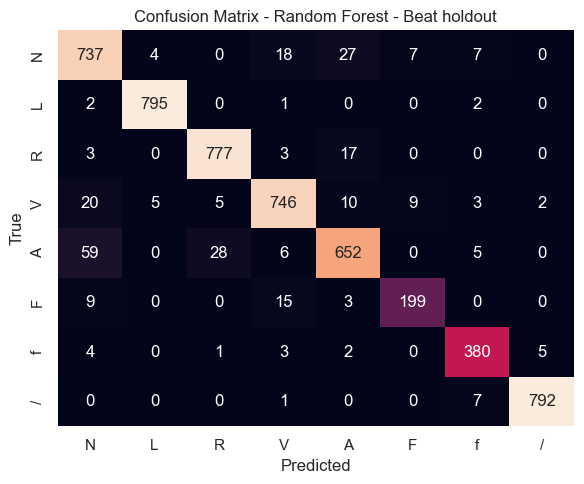

In [20]:
rf_beat = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
)

acc_rf_b, prec_rf_b, rec_rf_b, f1_rf_b, cm_rf_b = evaluate_and_report(
    rf_beat,
    X_train_beats, y_train_beats,
    X_test_beats,  y_test_beats,
    description="Random Forest - Beat holdout"
)


✨ 开始计算 Permutation Feature Importance
  → 使用 5-fold CV
  → 使用 5 个 slices，每 slice ≈ 55 点

📌 Fold 1/5 开始训练模型...
   ✓ baseline accuracy = 0.9850
   ✓ 开始对 slices 做 permutation...
     → slice 1/5  (范围 0:55)  完成，importance Δ=0.0051
     → slice 2/5  (范围 55:110)  完成，importance Δ=0.0036
     → slice 3/5  (范围 110:165)  完成，importance Δ=0.1701
     → slice 4/5  (范围 165:220)  完成，importance Δ=0.0213
     → slice 5/5  (范围 220:275)  完成，importance Δ=0.0104
📎 Fold 1 完成，用时 176.46 秒

📌 Fold 2/5 开始训练模型...
   ✓ baseline accuracy = 0.9848
   ✓ 开始对 slices 做 permutation...
     → slice 1/5  (范围 0:55)  完成，importance Δ=0.0052
     → slice 2/5  (范围 55:110)  完成，importance Δ=0.0035
     → slice 3/5  (范围 110:165)  完成，importance Δ=0.1695
     → slice 4/5  (范围 165:220)  完成，importance Δ=0.0189
     → slice 5/5  (范围 220:275)  完成，importance Δ=0.0087
📎 Fold 2 完成，用时 198.45 秒

📌 Fold 3/5 开始训练模型...
   ✓ baseline accuracy = 0.9846
   ✓ 开始对 slices 做 permutation...
     → slice 1/5  (范围 0:55)  完成，importance Δ=0.0040
     → sl

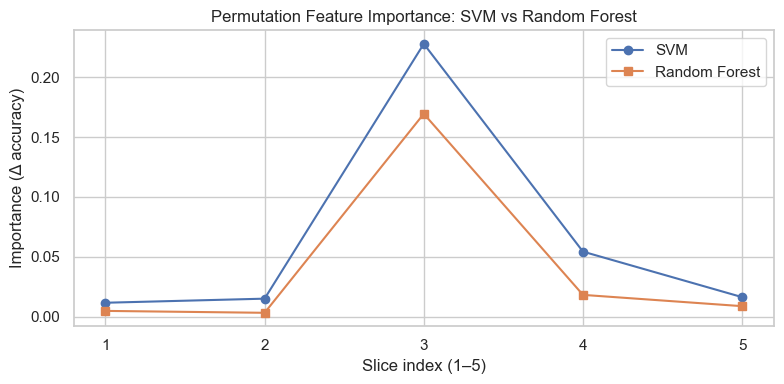

In [22]:
rf_for_pfi = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
)

rf_importances = permutation_feature_importance_slices_verbose(
    rf_for_pfi,
    X_all, y_all,
    n_slices=5,
    n_splits=5
)

plt.figure(figsize=(8,4))
plt.plot(slice_indices, svm_importances, marker='o', label='SVM')
plt.plot(slice_indices, rf_importances, marker='s', label='Random Forest')
plt.xlabel("Slice index (1–5)")
plt.ylabel("Importance (Δ accuracy)")
plt.title("Permutation Feature Importance: SVM vs Random Forest")
plt.legend()
plt.xticks(slice_indices)
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ut

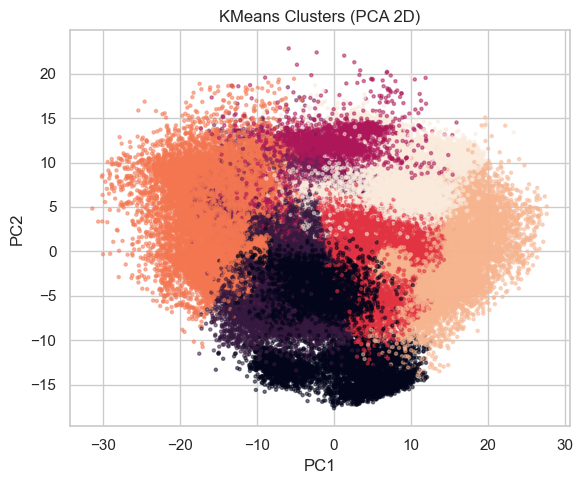

In [23]:
from sklearn.decomposition import PCA

# 为了可视化，先做 PCA 降到 2 维
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

pca = PCA(n_components=2, random_state=42)
X_all_pca = pca.fit_transform(X_all_scaled)

kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_all_scaled)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_all_pca[:,0], X_all_pca[:,1],
                      c=cluster_labels, s=5, alpha=0.5)
plt.title("KMeans Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


In [1]:
# 在训练集上拟合 k-means，再用多数投票作为“聚类分类器”
X_train_scaled = scaler.fit_transform(X_train_beats)
X_test_scaled = scaler.transform(X_test_beats)

kmeans_clf = KMeans(n_clusters=8, random_state=42, n_init=10)
train_clusters = kmeans_clf.fit_predict(X_train_scaled)
test_clusters = kmeans_clf.predict(X_test_scaled)

# 每个 cluster 里找出现频率最高的 true label
cluster_to_label = {}
for c in range(8):
    idx_c = np.where(train_clusters == c)[0]
    if len(idx_c) == 0:
        continue
    labels_c = y_train_beats[idx_c]
    majority_label = np.bincount(labels_c).argmax()
    cluster_to_label[c] = majority_label

print("Cluster to label mapping:", cluster_to_label)

# print(pd.Series(cluster_to_label).value_counts())
    
# 用这个映射在测试集上预测
y_pred_cluster = np.array([
    cluster_to_label.get(c, 1)  # 若没映射，默认预测成 Normal (1)
    for c in test_clusters
])

acc_c = accuracy_score(y_test_beats, y_pred_cluster)
prec_c, rec_c, f1_c, _ = precision_recall_fscore_support(
    y_test_beats, y_pred_cluster, average='weighted', zero_division=0
)

print("Cluster-based classifier on beat holdout:")
print(f"Accuracy : {acc_c:.4f}")
print(f"Precision: {prec_c:.4f}")
print(f"Recall   : {rec_c:.4f}")
print(f"F1-score : {f1_c:.4f}")


NameError: name 'scaler' is not defined